<a href="https://colab.research.google.com/github/paolobalasso/YoutubeTrading/blob/main/EconomicRegime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install yfinance
!pip install bt

%matplotlib inline

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import bt
import yfinance as yf



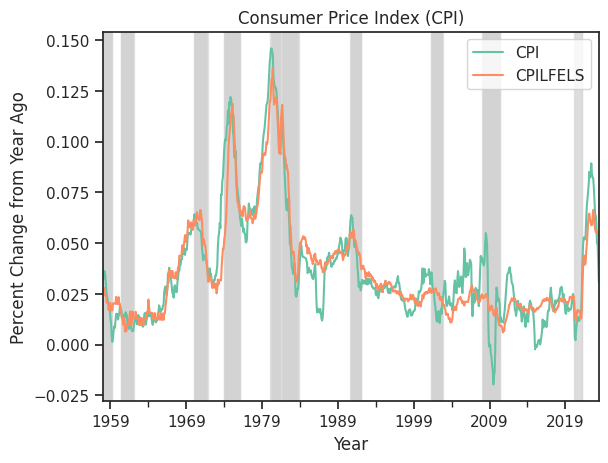

In [ ]:
# INFLATION
%matplotlib inline
import pandas as pd
import pandas_datareader as web

# Import the data
start_date = "1947-01-01"
end_date = "2024-06-30"
PCI = pd.DataFrame(dict(
    CPI = web.DataReader("CPIAUCSL", "fred", start_date, end_date)["CPIAUCSL"],
    CPILFELS = web.DataReader("CPILFESL", "fred", start_date, end_date)['CPILFESL']
)).fillna(method="ffill").pct_change(12).dropna()

# Define the recession periods
recession_dates = web.DataReader("USREC", "fred", start_date, end_date)

# Plot the line chart
# Plot the line chart
fig, ax = plt.subplots()
PCI.plot(ax=ax)

# Add the recession rectangles
for start_date, recession in zip(recession_dates.index, recession_dates["USREC"]):
    if recession == 1:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=365), color="lightgray", alpha=0.5)

# Add a title and labels
ax.set_title("Consumer Price Index (CPI)")
ax.set_xlabel("Year")
ax.set_ylabel("Percent Change from Year Ago")

# Show the plot
plt.show()

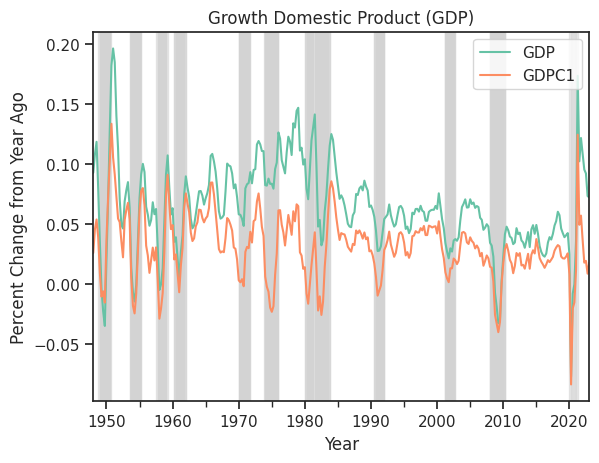

In [ ]:
# GDP
%matplotlib inline
import pandas as pd
import pandas_datareader as web

# Import the data
start_date = "1947-01-01"
end_date = "2024-06-30"
GDP = pd.DataFrame(dict(
    GDP = web.DataReader("GDP", "fred", start_date, end_date)["GDP"],
    GDPC1 = web.DataReader("GDPC1", "fred", start_date, end_date)['GDPC1']
)).fillna(method="ffill").pct_change(4).dropna()

# Define the recession periods
recession_dates = web.DataReader("USREC", "fred", start_date, end_date)

# Plot the line chart
# Plot the line chart
fig, ax = plt.subplots()
GDP.plot(ax=ax)

# Add the recession rectangles
for start_date, recession in zip(recession_dates.index, recession_dates["USREC"]):
    if recession == 1:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=365), color="lightgray", alpha=0.5)

# Add a title and labels
ax.set_title("Growth Domestic Product (GDP)")
ax.set_xlabel("Year")
ax.set_ylabel("Percent Change from Year Ago")

# Show the plot
plt.show()

In [ ]:
# Define the start and end date for the analysis

start_date = "1959-01-01"
end_date = "2024-01-01"

signals = pd.DataFrame(dict(GDP = web.DataReader("GDPC1", "fred", start_date, end_date)['GDPC1'],CPI = web.DataReader("CPILFESL", "fred", start_date, end_date)['CPILFESL'])).fillna(method='ffill').pct_change(12).dropna()
prices = yf.download(['IYC','IDU','IYZ','IYW','IYJ','IYH','IYF','IYE','IYK','IYM','IYR','IVV'],"2010-01-01",end = end_date)['Adj Close']
prices = prices.multiply(yf.download(['USDEUR=X'],'2010-01-04',end = end_date)['Close'],axis="index").dropna()

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
def InvestmentClockFixed(x,cuts={'GDP':2.5,'CPI':3}):

   x_ = x.copy().assign(Growth=None,Inflation=None,Theme=None)

   # define high and low growth
   x_.loc[x['GDP']<=cuts['GDP'],'Growth'] = 'low'
   x_.loc[x['GDP']>cuts['GDP'],'Growth'] = 'high'

   # define high and low inflation
   x_.loc[x['CPI']<=cuts['CPI'],'Inflation'] = 'low'
   x_.loc[x['CPI']>cuts['CPI'],'Inflation'] = 'high'

   # define investment clock phases
   x_.loc[(x_.Growth=='low')&(x_.Inflation=='low'),'Theme'] = 'Reflection'
   x_.loc[(x_.Growth=='high')&(x_.Inflation=='low'),'Theme'] = 'Recovery'
   x_.loc[(x_.Growth=='high')&(x_.Inflation=='high'),'Theme'] = 'Overheat'
   x_.loc[(x_.Growth=='low')&(x_.Inflation=='high'),'Theme'] = 'Stagflation'
   return x_.dropna()

<Figure size 1200x1600 with 0 Axes>

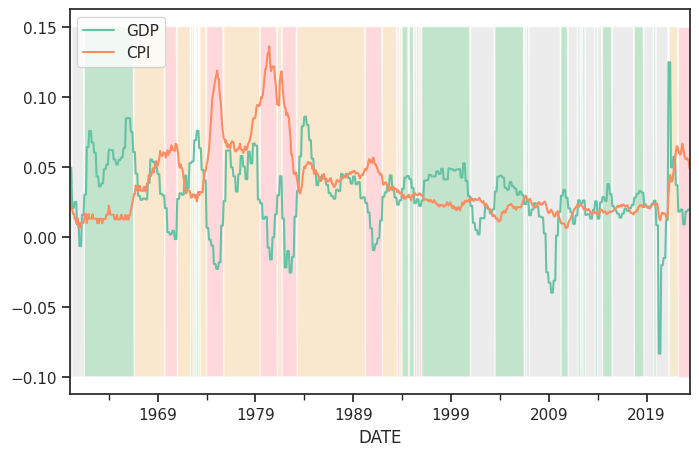

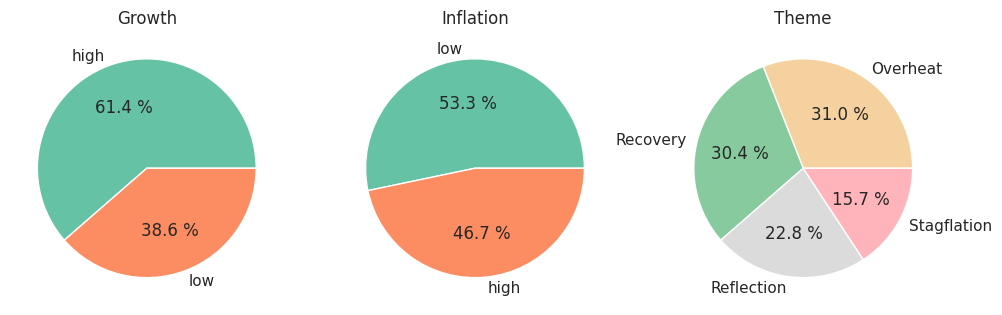

In [ ]:
themes = InvestmentClockFixed(signals, cuts={'GDP':0.025,'CPI':0.03})
fig = plt.figure(figsize=(12,16))

fig.suptitle('Investment Clock Themes with Fixed Cuts',fontsize=16)
y_lim = (-.1,.15)
colors = dict(
  Overheat='#f4d19e',
  Recovery='#87ca9d',
  Reflection='#dbdbdb',
  Stagflation='#ffb3ba'
)
fig = themes[['GDP','CPI']].plot(figsize=(8,5))
for t in ['Overheat','Recovery','Reflection','Stagflation']:
   fig.fill_between(
      themes.index, y_lim[0],y_lim[1],
      where=(themes.Theme==t),
      interpolate = True,
      facecolor=colors[t],
      alpha = 0.5
   )

fig, (ax2, ax3, ax4) = plt.subplots(ncols=3, nrows=1, figsize=(12, 16))
growth_counts=themes.Growth.value_counts()
ax2.pie(growth_counts,autopct='%.1f %%',
        labels=growth_counts.index)
ax2.set_title('Growth')
inflation_counts=themes.Inflation.value_counts()
ax3.pie(inflation_counts,autopct='%.1f %%',
        labels=inflation_counts.index)
ax3.set_title('Inflation')
theme_counts=themes.Theme.value_counts().sort_index(ascending=True)
ax4.pie(theme_counts,autopct='%.1f %%',
        labels=theme_counts.index,colors=colors.values())
ax4.set_title('Theme')
plt.show()